# Empirical Pseudopotential Sampling Tests

## Imports

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy.linalg import inv, norm, det
import matplotlib.pyplot as plt
from time import time

from BZI.pseudopots import *
from BZI.sampling import make_ptvecs, make_cell_points, make_grid
from BZI.symmetry import reduce_kpoint_list, make_ptvecs, make_rptvecs
from BZI.integration import rectangular_fermi_level, rectangular_method
from BZI.plots import plot_mesh

from opf_python.sym_grids import spGrids

## Free electron

In [174]:
nkpts_list = range(2,41)

# te_list = [[] for _ in range(1, nkpts)]
# te_err_list = [[] for _ in range(1, nkpts)]
# fl_list = [[] for _ in range(1, nkpts)]
# fl_err_list = [[] for _ in range(1, nkpts)]
# nirr_list = [[] for _ in range(1, nkpts)]

lat_vecs = free_PP.lattice.reciprocal_vectors

te1_list = []
te1_err_list = [] 
fl1_list = [] 
fl1_err_list = []

fl2_list = [] 
fl2_err_list = []
te2_list = []
te2_err_list = [] 

tot_list = []
nirr_list = []
for n in nkpts_list:
    grid_vecs = lat_vecs/n
    offset = -np.dot(inv(grid_vecs), np.sum(lat_vecs, 1)/2) + [.5]*3
    grid = make_grid(lat_vecs, grid_vecs, offset)
    tot_list.append(len(grid))
    reduced_grid, weights = reduce_kpoint_list(grid, lat_vecs, grid_vecs, offset)
    nirr_list.append(len(weights))
    # print("***weights*** ", weights)
    # print("***reduced grid *** \n", reduced_grid)
    free_PP.fermi_level = rectangular_fermi_level(free_PP, reduced_grid, weights)
    free_PP.total_energy = rectangular_method(free_PP, reduced_grid, weights)
    fl1_list.append(free_PP.fermi_level)
    te1_list.append(free_PP.total_energy)
    fl1_err_list.append(abs(free_PP.fermi_level_ans - free_PP.fermi_level))
    te1_err_list.append(abs(free_PP.total_energy_ans - free_PP.total_energy))
    weights = [1 for _ in range(len(grid))]
    free_PP.fermi_level = rectangular_fermi_level(free_PP, grid, weights)
    free_PP.total_energy = rectangular_method(free_PP, grid, weights)
    fl2_list.append(free_PP.fermi_level)
    te2_list.append(free_PP.total_energy)
    fl2_err_list.append(abs(free_PP.fermi_level_ans - free_PP.fermi_level))
    te2_err_list.append(abs(free_PP.total_energy_ans - free_PP.total_energy))

In [171]:
for i,j in zip(te1_list, te2_list):
    print(i, " ", j)

337.43498958   337.43498958
305.926982652   305.926982652
284.481428295   284.481428295
292.232358014   292.232358014
290.223441385   290.223441385
288.327170783   288.327170783
288.646683905   288.646683905
288.33885453   288.33885453
288.002795169   288.002795169
288.243923966   288.243923966
287.922924319   287.922924319
288.133354846   288.133354846
287.730598429   287.730598429
287.972899187   287.972899187
287.906644562   287.906644562
287.852066053   287.852066053
287.811393449   287.811393449
287.856488628   287.856488628
287.791116262   287.791116262


In [175]:
free_PP.total_energy_ans

287.76935243386754

<IPython.core.display.Javascript object>


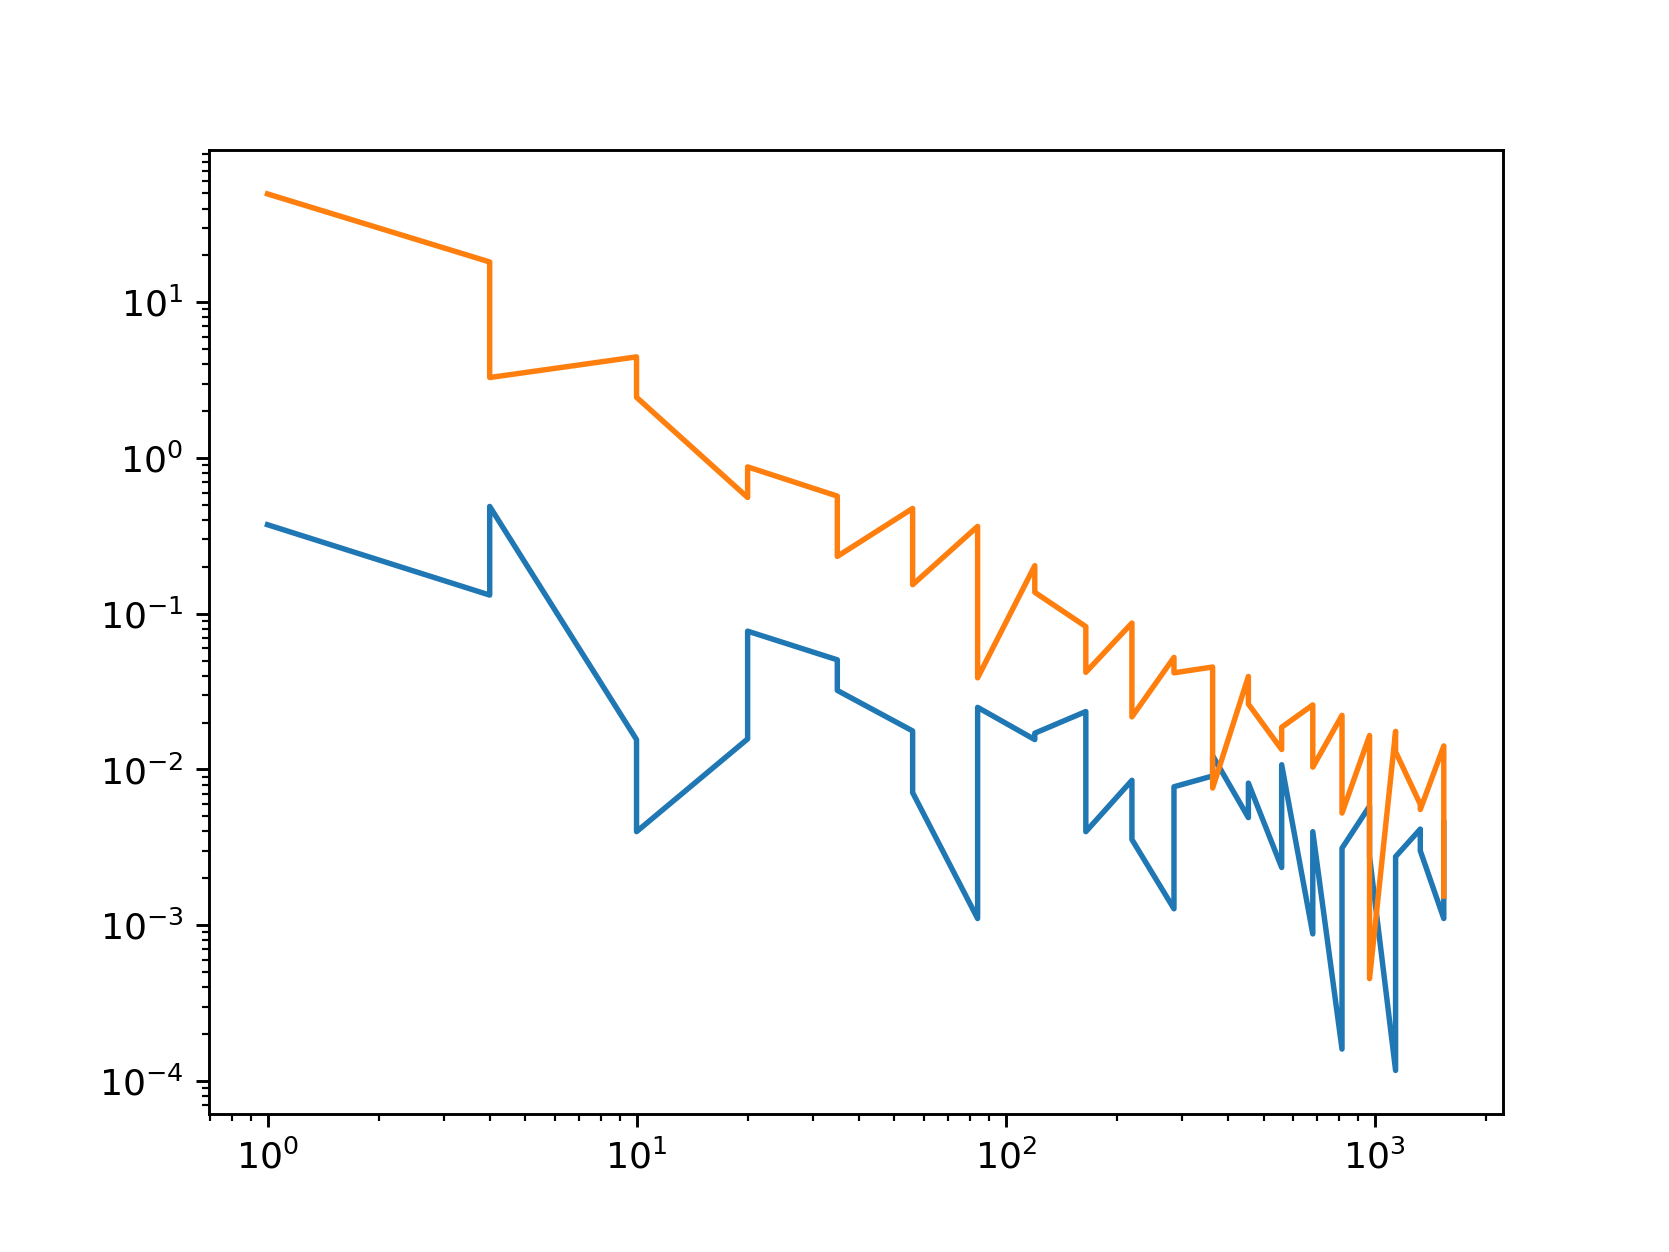

In [176]:
plt.loglog(nirr_list, fl1_err_list, label="fermi level")
plt.loglog(nirr_list, te1_err_list, label="total energy")
plt.show()

In [81]:
plt.loglog(nirr_list, fl2_err_list, label="fermi level")
plt.loglog(nirr_list, te2_err_list, label="total energy")
plt.show()

<IPython.core.display.Javascript object>


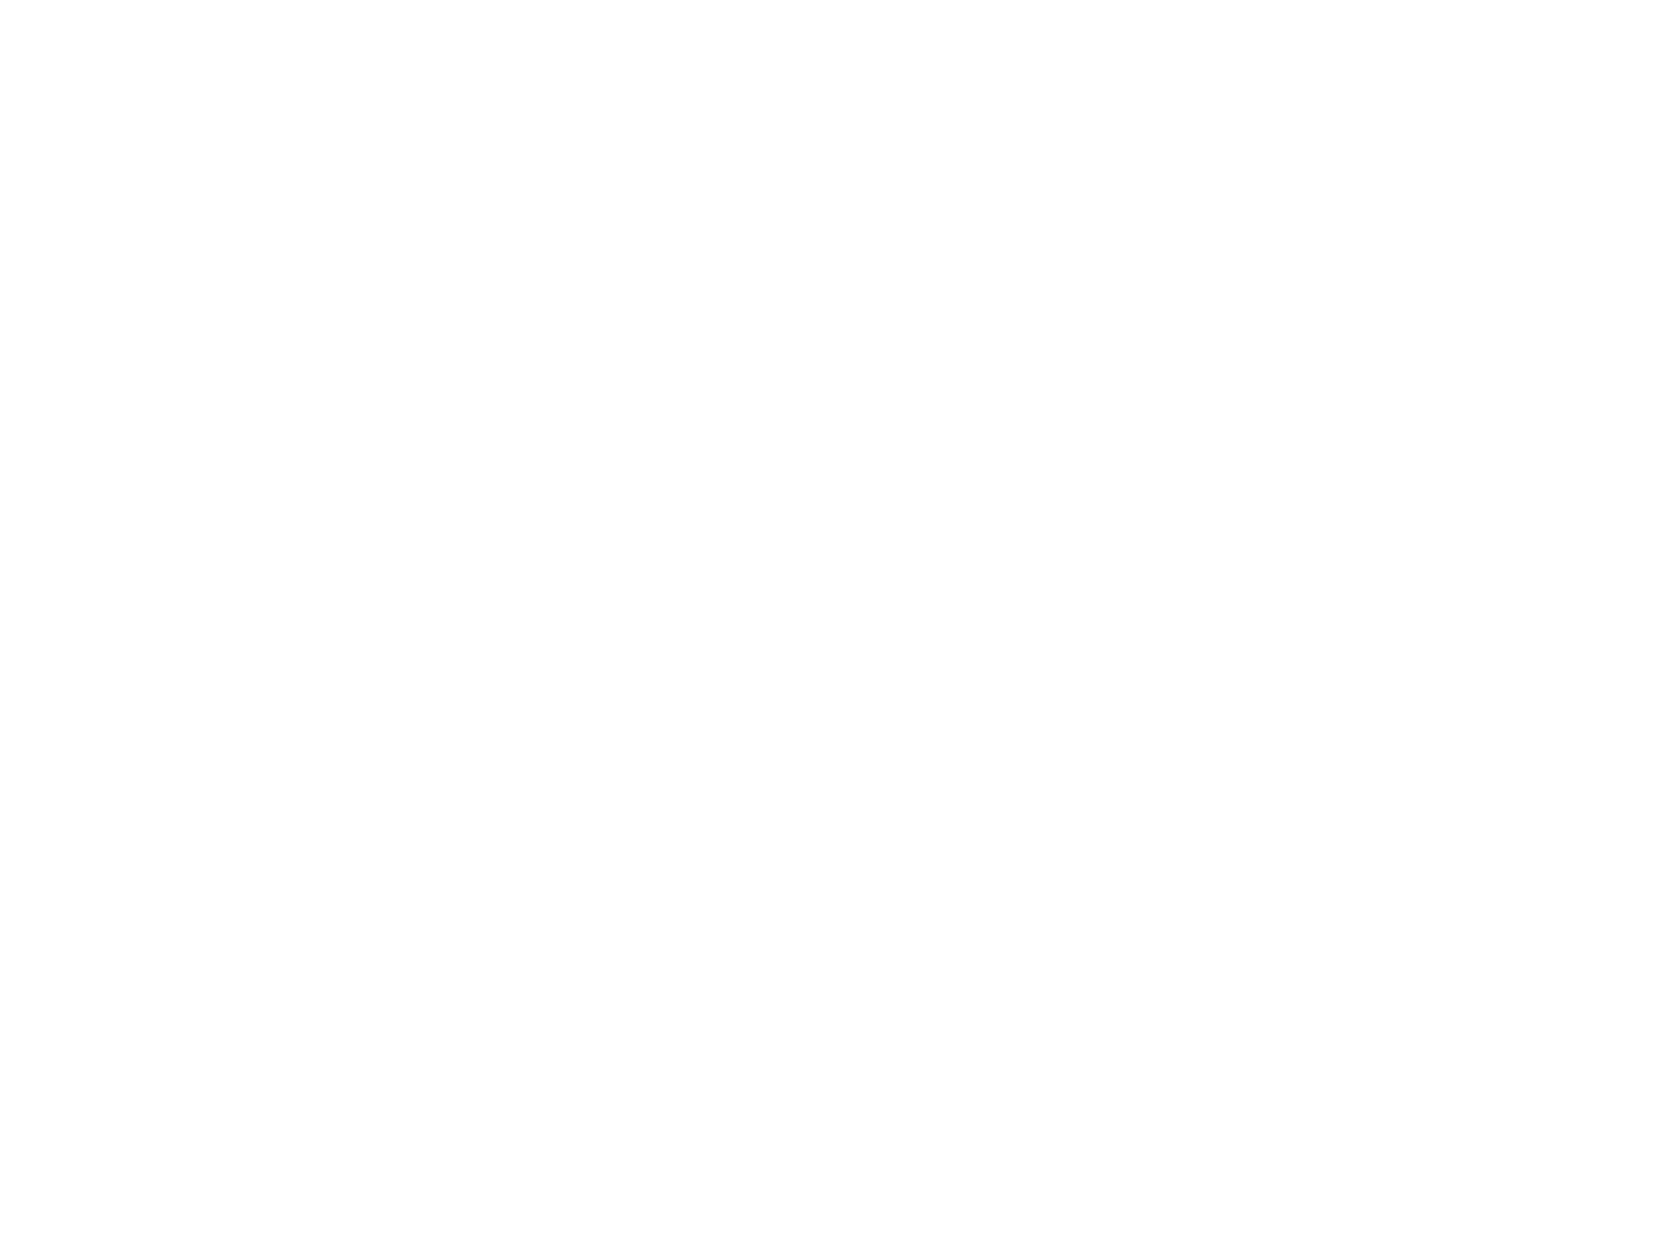

In [99]:
plot_mesh(grid, lat_vecs, -np.sum(lat_vecs, 1)/2)

<IPython.core.display.Javascript object>


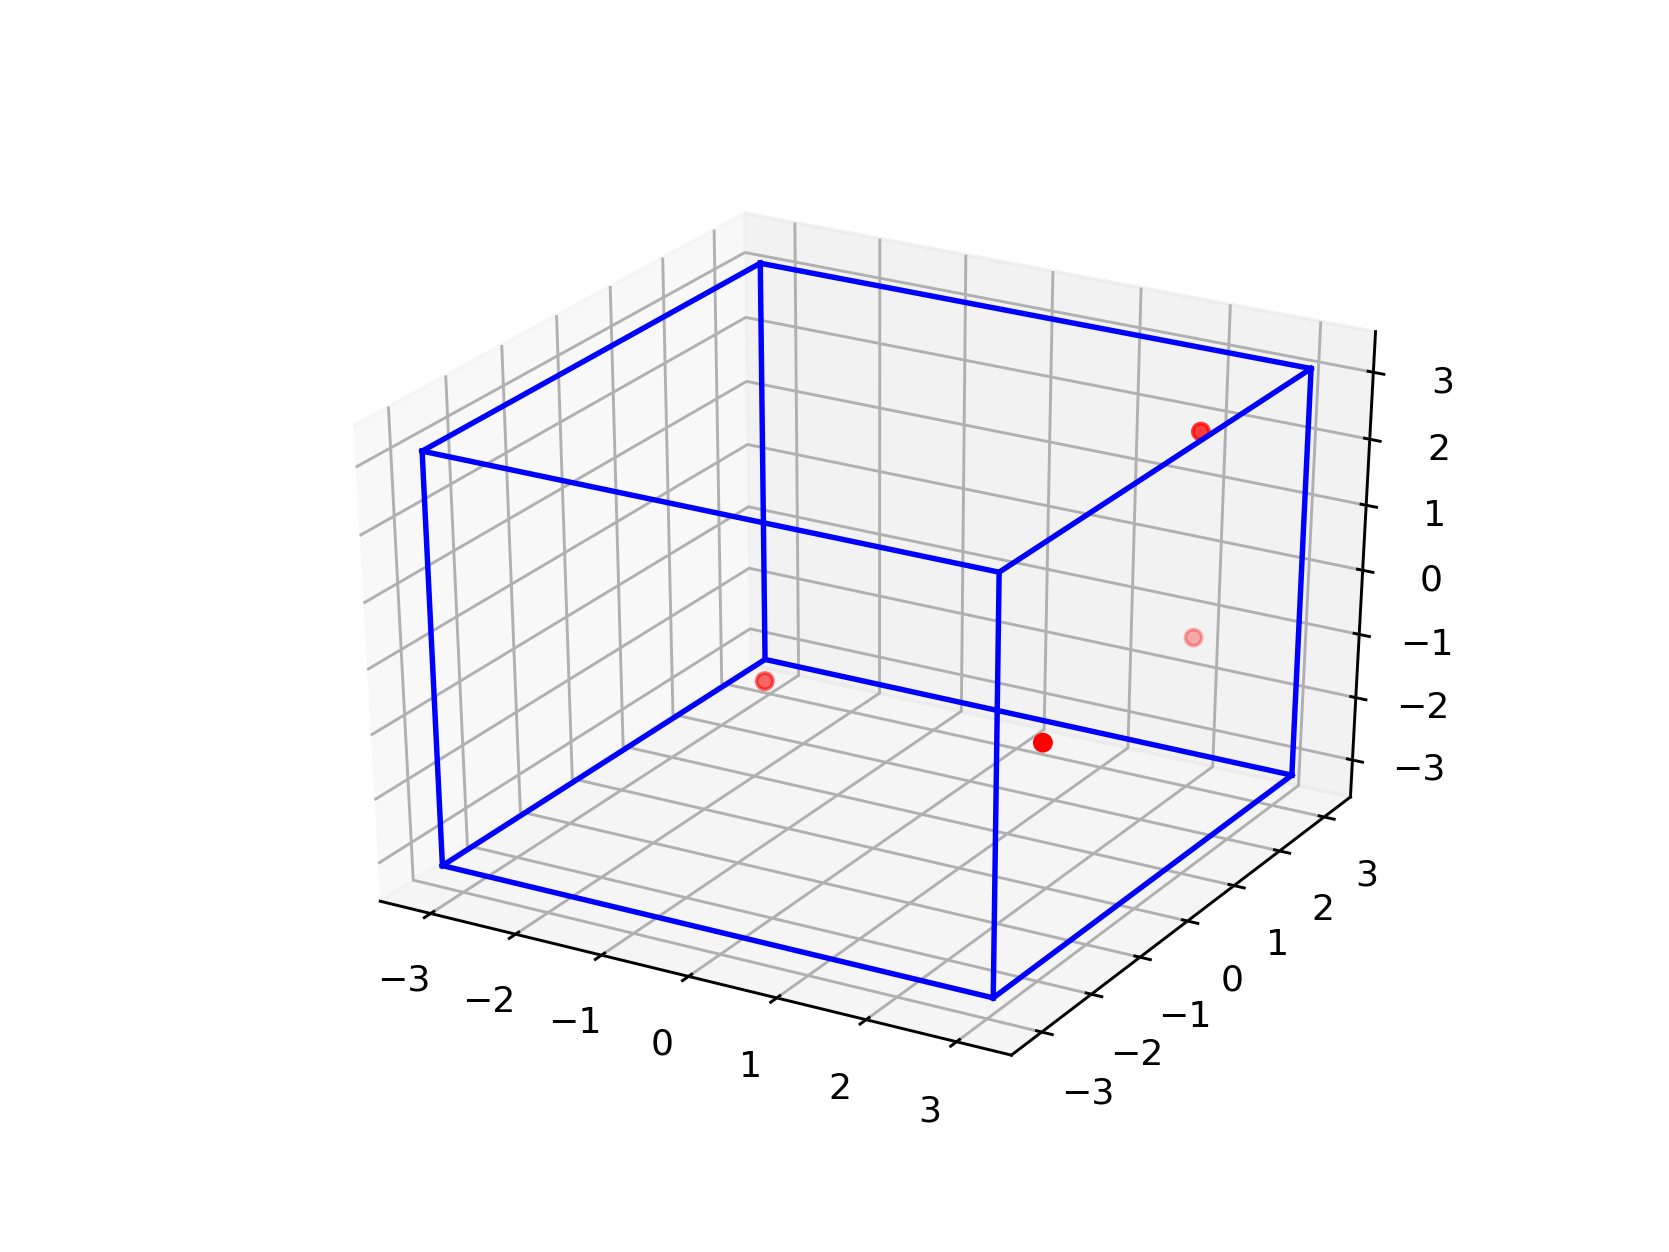

In [98]:
plot_mesh(reduced_grid, lat_vecs, -np.sum(lat_vecs, 1)/2)

In [100]:
from BZI.symmetry import find_orbitals

In [102]:
orbs = find_orbitals(grid, lat_vecs)

## Zn Tests

In [104]:
reduced_grid

[array([-0.78539816, -0.78539816, -0.78539816]),
 array([ 2.35619449, -0.78539816, -0.78539816]),
 array([ 2.35619449,  2.35619449, -0.78539816]),
 array([ 2.35619449,  2.35619449,  2.35619449])]

In [103]:
for v in orbs.values():
    print(len(v))

8
24
24
8


### Find the converged Fermi level and total energy.

In [17]:
nkpt_list = []
for n in range(1,1000):
    grid_dict = spGrids(Zn_PP.lattice.reciprocal_vectors, n)
    if len(grid_dict) > 9:
        nkpt_list.append(n)
    print(n)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [18]:
offset_list = [[0.]*3, [0., 0., 0.5], [0., 0.5, 0.5], [0.5, 0.5, 0.5]]

te_list = [[[] for _ in range(len(nkpt_list))] for _ in range(len(offset_list))]
fl_list = [[[] for _ in range(len(nkpt_list))] for _ in range(len(offset_list))]
te_err_list = [[[] for _ in range(len(nkpt_list))] for _ in range(len(offset_list))]
fl_err_list = [[[] for _ in range(len(nkpt_list))] for _ in range(len(offset_list))]
rmin_list = [[[] for _ in range(len(nkpt_list))] for _ in range(len(offset_list))]
pack_list = [[[] for _ in range(len(nkpt_list))] for _ in range(len(offset_list))]
nirr_list = [[[] for _ in range(len(nkpt_list))] for _ in range(len(offset_list))]
for i, offset in offset_list:
    for j,nkpt in enumerate(nkpt_list):
        for grid_dict in spGrids(Zn_PP.lattice.reciprocal_vectors, n):
            # Unpack grid dictionary
            grid_vecs = 2*np.pi*grid_dict["grid_vecs"]
            pack_list[i,j].append(grid_dict["packing_frac"])
            rmin_list[i,j].append(grid_dict["rmin"])

            # Create the grid and reduce it
            grid = make_cell_points(Zn_PP.lattice.reciprocal_vectors, grid_vecs, offset)
            reduced_grid, weights = reduce_kpoint_list(grid, Zn_PP.lattice.reciprocal_vectors, grid_vecs,
                                              offset)
            nirr_list[i,j].append(len(reduced_grid))
            
            # Calculate the Fermi level, total energy and their errors.
            fl_list[i,j].append(rectangular_fermi_level(Zn_PP, reduced_grid, weights))
            te_list[i,j].append(rectangular_method(Zn_PP, reduced_grid, weights))
            fl_err_list = 
            

[324, 432, 576, 648, 768, 864, 900, 972]